# 2.3 - Macrobond web API - Screening with a Keyword

*Performing coverage checks based on a keyword*

This notebook aims to provide examples of how to use Macrobond's web API call methods as well as insights on the key attributes used to display the output in an understandable format.

We will focus here on using the Search method based on a **keyword** filter. This helps you build a list of time series potentially relating to a common theme.

*Full error handling is omitted for brevity*

***

## Importing packages

In [1]:
import pandas
from matplotlib import pyplot

from macrobond_financial.common import Credentials
from macrobond_financial.web import WebClient

***

## Authentication

If you have a Macrobond's web API account, enter your *client_id* and *client_secret* below.

In [2]:
credentials = Credentials()

***

## Get the data - Keyword: Government Securities Auctions

Note that we are using here the Search endpoint with filters on keyword `text=Government Securities Auctions` and `Frequency=daily` time series in this example.

Feel free to refer to https://api.macrobondfinancial.com/swagger/index.html to get the comprehensive list of web API endpoints and parameters used.

***

## Visualising the data
Let's evaluate Macrobond's coverage for daily time series related to government securities auctions.

In [3]:
with WebClient(credentials.client_id, credentials.client_secret) as api:
    data_frame = api.search(
        text="Government Securities Auctions",
        entity_types="TimeSeries",
        must_have_values={"Frequency": "daily"},
        include_discontinued=False,
    ).data_frame(
        columns=[
            "Name",
            "FullDescription",
            "Description",
            "Region",
            "Category",
            "Frequency",
            "Source",
            "Class",
            "PriceType",
        ]
    )
data_frame.head(10)

,Name,FullDescription,Description,Region,Category,Frequency,Source,Class,PriceType
0,phrate0011,"Philippines, Government Securities Auctions, T...",Treasury Bill Rate,[ph],rate,daily,src_phbsp,step,[intrate]
1,esgpfi0237,"Spain, Government Securities Auctions, Treasur...","Treasury Bills, Average Rate",[es],gpfi,daily,src_estesoro,stock,[yield]
2,esgpfi0345,"Spain, Government Securities Auctions, Inflati...","Inflation Linked Bonds, Average Rate",[es],gpfi,daily,src_estesoro,stock,[yield]
3,phrate0057,"Philippines, Government Securities Auctions, T...",Treasury Bonds,[ph],rate,daily,src_phbsp,stock,[coupon]
4,esgpfi0232,"Spain, Government Securities Auctions, Treasur...","Treasury Bills, Average Rate",[es],gpfi,daily,src_estesoro,stock,[yield]
5,esgpfi0222,"Spain, Government Securities Auctions, Treasur...","Treasury Bills, Average Rate",[es],gpfi,daily,src_estesoro,stock,[yield]
6,esgpfi0255,"Spain, Government Securities Auctions, Treasur...","Treasury Bonds, Average Rate",[es],gpfi,daily,src_estesoro,stock,[yield]
7,esgpfi0217,"Spain, Government Securities Auctions, Treasur...","Treasury Bills, Average Rate",[es],gpfi,daily,src_estesoro,stock,[yield]
8,serate0947,"Sweden, Government Securities Auctions, Certif...",NaN,[se],rate,daily,src_swrb,stock,[rate]
9,caboc_totamo_nom,"Canada, Government Securities Auctions, Nomina...",Total,[ca],rate,daily,src_caboc,flow,[amofer]


### Let's make sense of the attribute PriceType

We will use here the metadata endpoint from the web API as detailed in the notebook **1.1 - Macrobond web API - Metadata Navigation**

In [4]:
with WebClient(credentials.client_id, credentials.client_secret) as api:
    data_frame = api.get_attribute_information("PriceType").data_frame()
data_frame

,name,description,comment,value_type,uses_value_list,can_list_values,can_have_multiple_values,is_database_entity
0,PriceType,Price type,Provides additional information for price rela...,8,True,True,True,False


As the PriceType uses values from list and is not a free text attribute, let's have a look at its values to be used later as a group.

In [5]:
with WebClient(credentials.client_id, credentials.client_secret) as api:
    df3 = api.list_values("PriceType").data_frame(
        columns=["value", "description", "comment"]
    )
df3

,value,description,comment
0,intrate,Average Interest Rate,None
1,yield,Yield,None
2,coupon,Coupon,None
3,rate,Interest Rate,None
4,amofer,Amount Offered,None
...,...,...,...
649,secmarmidrat,Secondary Market Mid Rate,None
650,salgr,Sales Growth,None
651,iprice,Issue Price,None
652,swprice,Switching Price,None


Now that we get a sense of potential groupings we can achieve thanks to the metadata, let's manipulate the ones that will be used.

In [6]:
with WebClient(credentials.client_id, credentials.client_secret) as api:
    data_frame = api.search(
        text="Government Securities Auctions",
        entity_types="TimeSeries",
        must_have_values={"Frequency": "daily"},
        include_discontinued=False,
    ).data_frame(
        columns=[
            "Name",
            "FullDescription",
            "Description",
            "Region",
            "Category",
            "Frequency",
            "Source",
            "Class",
            "PriceType",
        ]
    )

data_frame["RegionString"] = data_frame["Region"].apply(
    lambda x: "" if pandas.isna(x) else ", ".join(map(str, x))
)

# Need to account for NaN values before converting to a string
data_frame["PriceTypeS"] = data_frame["PriceType"].fillna("")
data_frame["PriceTypeString"] = data_frame["PriceTypeS"].apply(
    lambda x: ", ".join(map(str, x))
)

# Mapping the PriceType to its descriptions
mapping = dict(df3[["value", "description"]].values)
data_frame["PriceTypeD"] = data_frame.PriceTypeString.map(mapping)
data_frame.head(1)

,Name,FullDescription,Description,Region,Category,Frequency,Source,Class,PriceType,RegionString,PriceTypeS,PriceTypeString,PriceTypeD
0,phrate0011,"Philippines, Government Securities Auctions, T...",Treasury Bill Rate,[ph],rate,daily,src_phbsp,step,[intrate],ph,[intrate],intrate,Average Interest Rate


### Displaying the new DataFrame
Let's see how our transformations have been applied by isolating on a few columns: `df.iloc[rows,[columns]]`.

In [7]:
df_final = data_frame.iloc[0:12000, [0, 1, 2, 3, 9, 4, 6, 12]]
df_final.head(10)

,Name,FullDescription,Description,Region,RegionString,Category,Source,PriceTypeD
0,phrate0011,"Philippines, Government Securities Auctions, T...",Treasury Bill Rate,[ph],ph,rate,src_phbsp,Average Interest Rate
1,esgpfi0237,"Spain, Government Securities Auctions, Treasur...","Treasury Bills, Average Rate",[es],es,gpfi,src_estesoro,Yield
2,esgpfi0345,"Spain, Government Securities Auctions, Inflati...","Inflation Linked Bonds, Average Rate",[es],es,gpfi,src_estesoro,Yield
3,phrate0057,"Philippines, Government Securities Auctions, T...",Treasury Bonds,[ph],ph,rate,src_phbsp,Coupon
4,esgpfi0232,"Spain, Government Securities Auctions, Treasur...","Treasury Bills, Average Rate",[es],es,gpfi,src_estesoro,Yield
5,esgpfi0222,"Spain, Government Securities Auctions, Treasur...","Treasury Bills, Average Rate",[es],es,gpfi,src_estesoro,Yield
6,esgpfi0255,"Spain, Government Securities Auctions, Treasur...","Treasury Bonds, Average Rate",[es],es,gpfi,src_estesoro,Yield
7,esgpfi0217,"Spain, Government Securities Auctions, Treasur...","Treasury Bills, Average Rate",[es],es,gpfi,src_estesoro,Yield
8,serate0947,"Sweden, Government Securities Auctions, Certif...",NaN,[se],se,rate,src_swrb,Interest Rate
9,caboc_totamo_nom,"Canada, Government Securities Auctions, Nomina...",Total,[ca],ca,rate,src_caboc,Amount Offered


### Group the results by PriceType

In [8]:
df_group1 = df_final.groupby(["PriceTypeD"])["Name"].count().reset_index(name="Count")
df_group1.sort_values(by="Count", ascending=False)

,PriceTypeD,Count
24,Offered,836
30,Yield,578
9,Average Price,434
10,Average Yield,430
25,Price,394
26,Sales,309
15,Demand,304
27,Tendered,264
23,Number of Bids,262
6,Amount Received,168


Let's isolate the top 10 results of our dataframe to keep the top price types.

In [9]:
df_group1_top = df_group1.nlargest(10, "Count")

### Group the results by Region

In [10]:
with WebClient(credentials.client_id, credentials.client_secret) as api:
    df4 = api.list_values("Region").data_frame(
        columns=["value", "description"]
    )

    # Mapping the Region value to its description
    mapping = dict(df4[["value", "description"]].values)
    df_final["RegionD"] = data_frame.RegionString.map(mapping)

    # Applying the grouping
    df_group2 = df_final.groupby(["RegionD"])["Name"].count().reset_index(name="Count")
    df_group2.sort_values(by="Count", ascending=False)
df_group2

,RegionD,Count
0,Canada,80
1,Egypt,4
2,France,504
3,Germany,117
4,Indonesia,1
5,Italy,917
6,Japan,98
7,Philippines,7
8,Poland,1890
9,Spain,181


In [11]:
df_group2 = (
    df_final.groupby(["RegionD", "PriceTypeD"])["Name"]
    .count()
    .reset_index(name="Count")
)
# df_group2.sort_values(['RegionD','Count'], ascending=False)
heatmap = df_group2.loc[
    (df_group2["RegionD"] == "Poland")
    & (
        (df_group2["PriceTypeD"] == "Yield")
        | (df_group2["PriceTypeD"] == "Offered")
        | (df_group2["PriceTypeD"] == "Price")
        | (df_group2["PriceTypeD"] == "Sales")
    )
    | (df_group2["RegionD"] == "United States")
    & (
        (df_group2["PriceTypeD"] == "Yield")
        | (df_group2["PriceTypeD"] == "Offered")
        | (df_group2["PriceTypeD"] == "Price")
        | (df_group2["PriceTypeD"] == "Sales")
    )
    | (df_group2["RegionD"] == "Sweden")
    & (
        (df_group2["PriceTypeD"] == "Yield")
        | (df_group2["PriceTypeD"] == "Offered")
        | (df_group2["PriceTypeD"] == "Price")
        | (df_group2["PriceTypeD"] == "Sales")
    )
]
heatmap

,RegionD,PriceTypeD,Count
34,Poland,Offered,309
35,Poland,Price,358
36,Poland,Sales,309
37,Poland,Yield,285
49,Sweden,Offered,134
52,Sweden,Yield,180
62,United States,Price,23
63,United States,Yield,20


### Plot the Government Securities Auctions Top by type and region

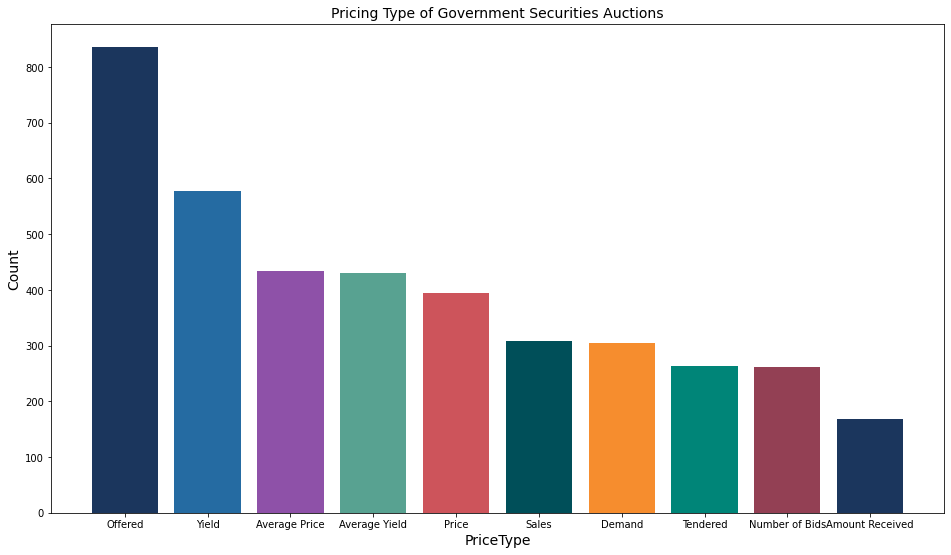

In [12]:
pyplot.rcParams["figure.figsize"] = [16, 9]

colours = [
    (27 / 255, 54 / 255, 93 / 255),
    (37 / 255, 107 / 255, 162 / 255),
    (142 / 255, 81 / 255, 168 / 255),
    (88 / 255, 162 / 255, 145 / 255),
    (205 / 255, 84 / 255, 91 / 255),
    (0 / 255, 79 / 255, 89 / 255),
    (246 / 255, 141 / 255, 46 / 255),
    (0 / 255, 133 / 255, 120 / 255),
    (147 / 255, 64 / 255, 84 / 255),
]
pyplot.bar(df_group1_top["PriceTypeD"], df_group1_top["Count"], color=colours)
pyplot.title("Pricing Type of Government Securities Auctions", fontsize=14)
pyplot.xlabel("PriceType", fontsize=14)
pyplot.ylabel("Count", fontsize=14)
pyplot.grid(False)
pyplot.autoscale()
pyplot.show()

Let's visualise the Price Type for Poland and Sweden only.

In [13]:
df_final_filtered = df_final.loc[
    (df_final["RegionD"] == "Poland") | (df_final["RegionD"] == "Sweden")
]

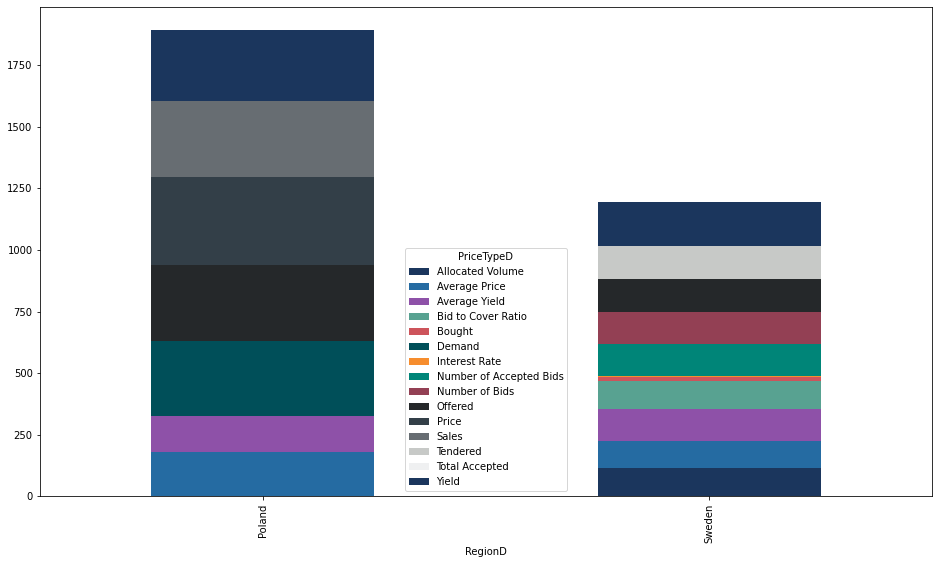

In [14]:
colours = [
    (27 / 255, 54 / 255, 93 / 255),
    (37 / 255, 107 / 255, 162 / 255),
    (142 / 255, 81 / 255, 168 / 255),
    (88 / 255, 162 / 255, 145 / 255),
    (205 / 255, 84 / 255, 91 / 255),
    (0 / 255, 79 / 255, 89 / 255),
    (246 / 255, 141 / 255, 46 / 255),
    (0 / 255, 133 / 255, 120 / 255),
    (147 / 255, 64 / 255, 84 / 255),
    (37 / 255, 40 / 255, 42 / 255),
    (51 / 255, 63 / 255, 72 / 255),
    (103 / 255, 109 / 255, 114 / 255),
    (199 / 255, 201 / 255, 199 / 255),
    (239 / 255, 240 / 255, 241 / 255),
]
df_final_filtered.groupby(["RegionD", "PriceTypeD"]).size().unstack().plot(
    kind="bar", stacked=True, color=colours
)
pyplot.show()